# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly_express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

### Consolidar Base de Dados

In [2]:
meses = {'jan' : 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun' : 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_base = pathlib.Path('archive')
bases = []

for arquivo in caminho_base.iterdir(): # cria uma lista que iterage com todos os arquivos
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]

    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))

    df = pd.read_csv(caminho_base / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes
    bases.append(df)

base_airbnb = pd.concat(bases)
#display(base_airbnb)

C:\Users\gui-s\AppData\Local\Temp\ipykernel_8532\1242269791.py:13: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_base / arquivo.name)
C:\Users\gui-s\AppData\Local\Temp\ipykernel_8532\1242269791.py:13: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_base / arquivo.name)
C:\Users\gui-s\AppData\Local\Temp\ipykernel_8532\1242269791.py:13: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_base / arquivo.name)
C:\Users\gui-s\AppData\Local\Temp\ipykernel_8532\1242269791.py:13: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_base / arquivo.name)
C:\Users\gui-s\AppData\Local\Temp\ipykernel_8532\1242269791.py:13: DtypeWarning: Columns (61,62,94) have mixed types. Spe

### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

- colunas a serem removidas
    1. Ids, Links, e Informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão mesma informação para o modelo) Ex: Ano/Mês
    3. Colunas preechidas com texto livre -> não rodaremos nenhuma analise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais

Se o arquivo "primeiros_registros" já estiver criado não é necessario rodar essa celula de código

In [3]:


#print(list(base_airbnb.columns))
#base_airbnb.head(1000).to_csv("primeiros_registros.csv", sep=';')

#### Depois da analise qualitativa das colunas, ficamos com as seguintes colunas:

In [4]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes'
]

base_airbnb = base_airbnb.loc[:, colunas]


### Tratar Valores Faltando

 - Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluidas da analise

 - Para as outras colunas, como temos muitos dados(mais de 900.000 linhas) vamos excluir as linhas que contém os dados NaN
 

In [5]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)

print(base_airbnb.isnull().sum())
print(base_airbnb.shape)

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64
(902210, 23)


In [6]:
base_airbnb = base_airbnb.dropna()
print(base_airbnb.shape)
print(base_airbnb.isnull().sum())


(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [7]:
print(base_airbnb.dtypes)
print('-' * 60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

 - Como preço e extra_people estão sendo reconhecidos como objetos ao inves de ser como um float temos que mudar o tipo de variavel da coluna

In [8]:
base_airbnb['price'] = base_airbnb['price'].astype(str)
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(str)

# price 
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

#extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

#vericando os tipos
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Vamos olhar feature por feature para: 

    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5x Amplitude e valores acima de Q3 + 1.5x Amplitude).Amplitude = Q3- Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir

- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numericos contínuos.
- Depois vamos analisar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.



<Axes: >

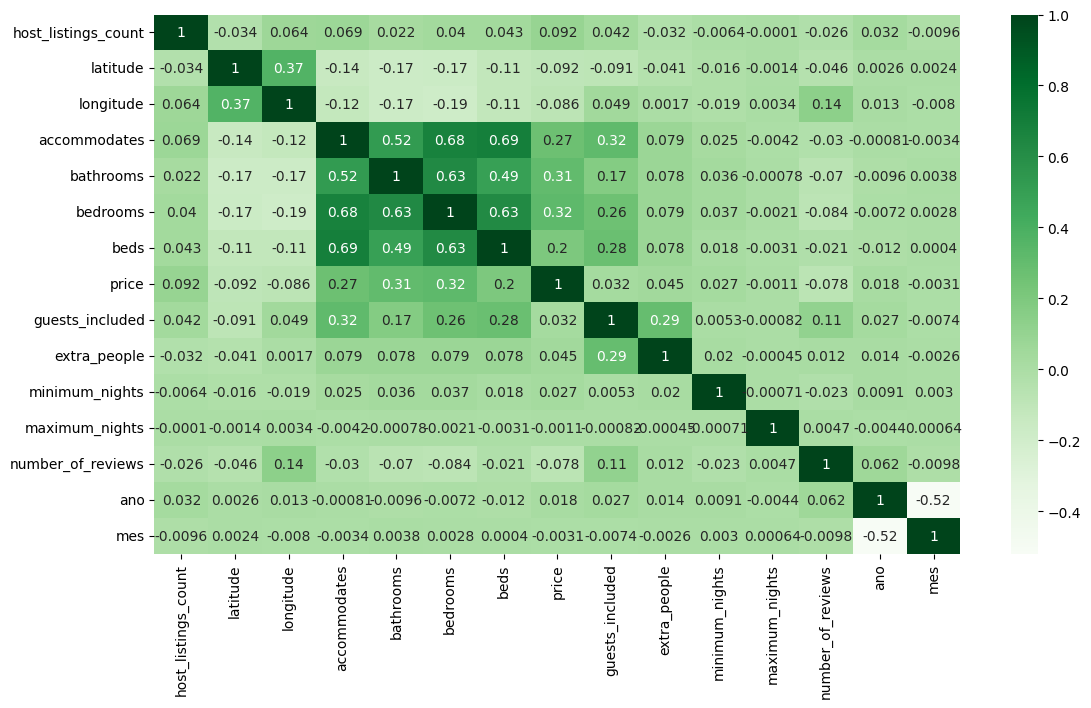

In [9]:
plt.figure(figsize=(13, 7))
sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap='Greens' )

# print(base_airbnb.corr(numeric_only=True))


### Definição de funções para analise de outliers


In [10]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 + amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

In [11]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches = (30, 20)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.histplot(coluna, kde=False )

def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax =sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

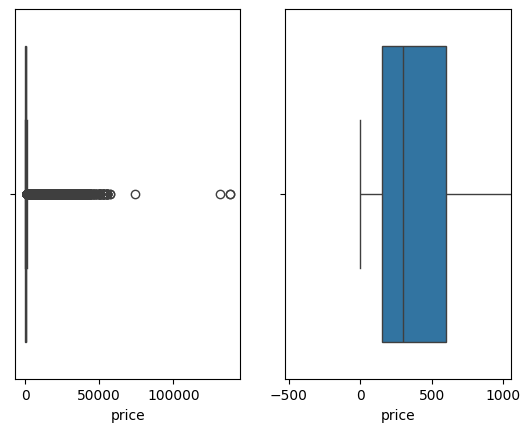

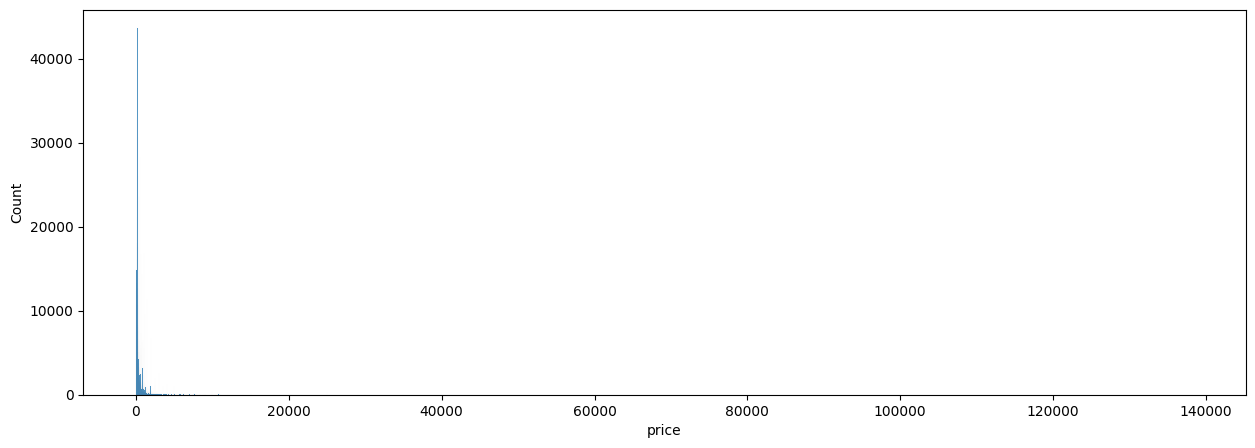

In [12]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

### PRICE

Como estamos contruindo um modelo para imoveis comuns, acredito que os valores acima do limete superior são apenas apartamentos de altissimio luxo, que não é nosso objetivo principal. Por isso podemos excluir esses outliers.

In [13]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print(f'{linhas_removidas} linhas removidas')

112004 linhas removidas


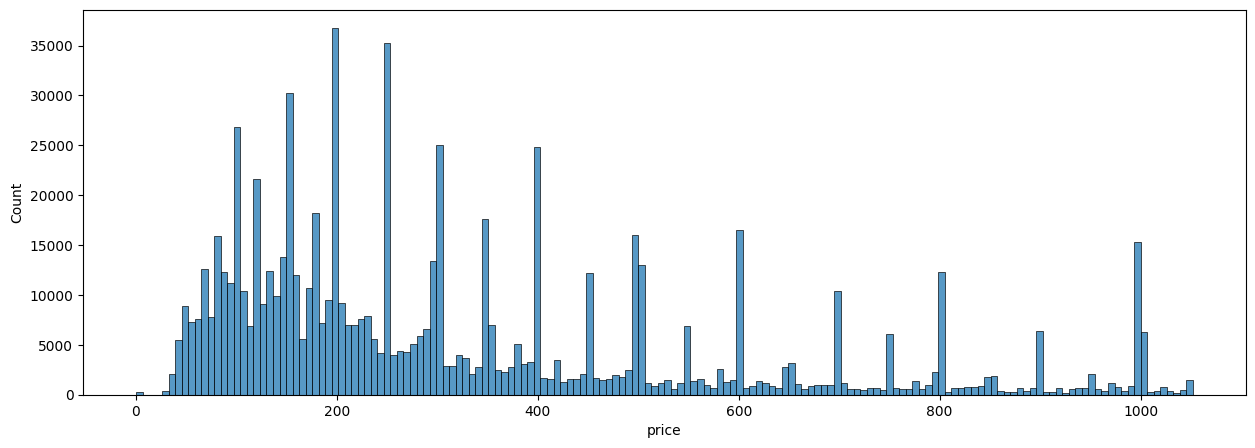

In [14]:
histograma(base_airbnb['price'])

### EXTRA PEOPLE

66046 linhas removidas


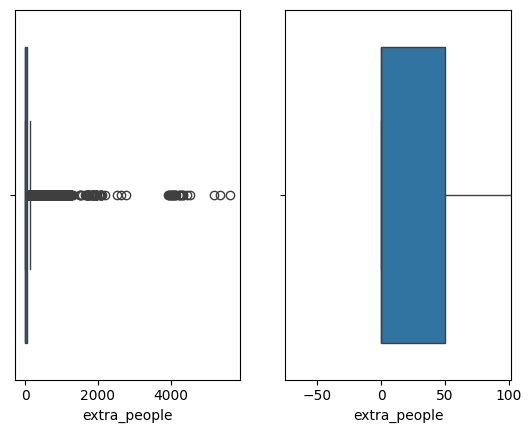

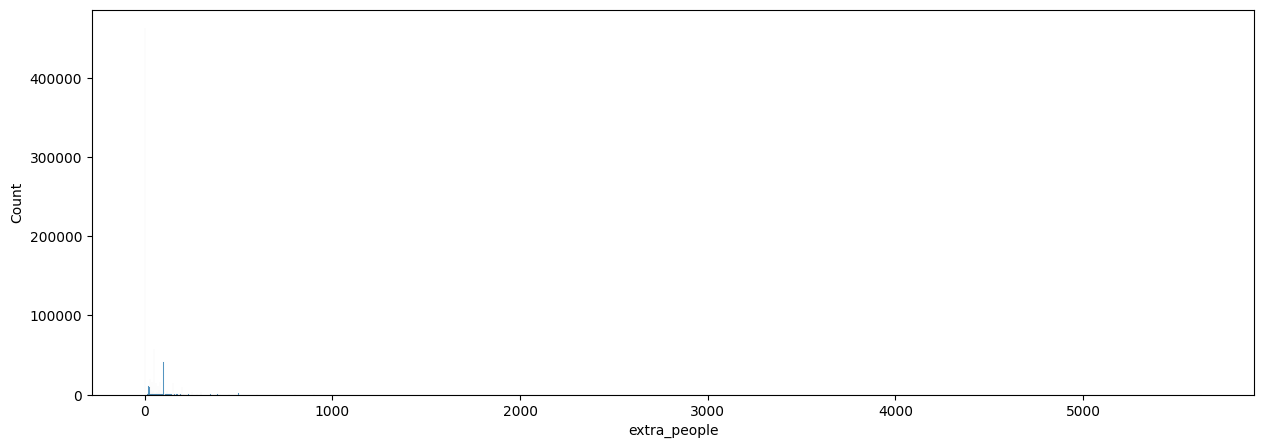

In [15]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print(f'{linhas_removidas} linhas removidas')

### host_listings_count

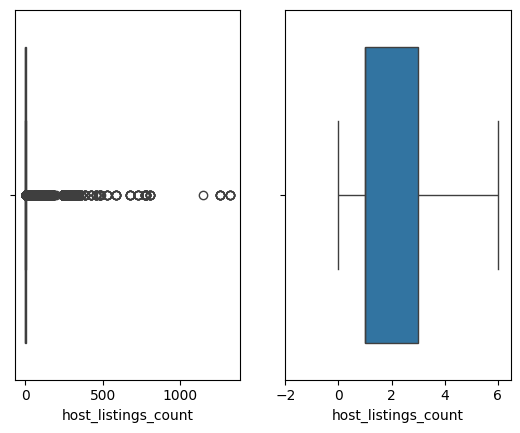

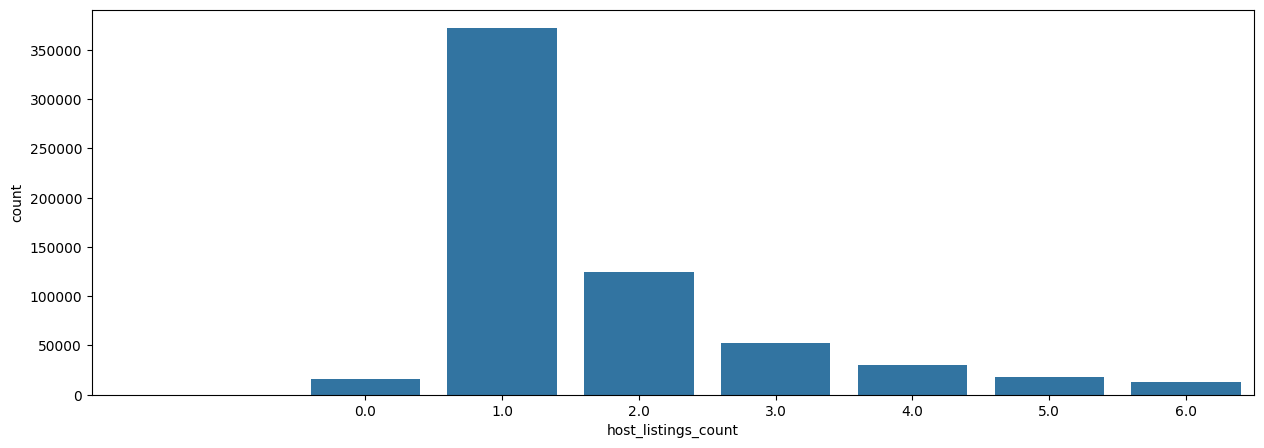

In [16]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imoveis no airbnb não é o publico alvo do objetivo do projeto

In [17]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print(f'{linhas_removidas} linhas removidas')

93837 linhas removidas


### accommodates

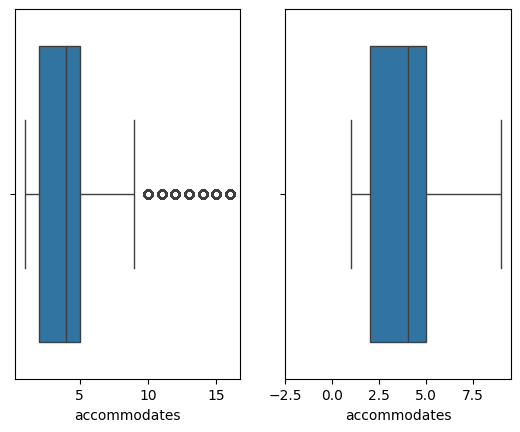

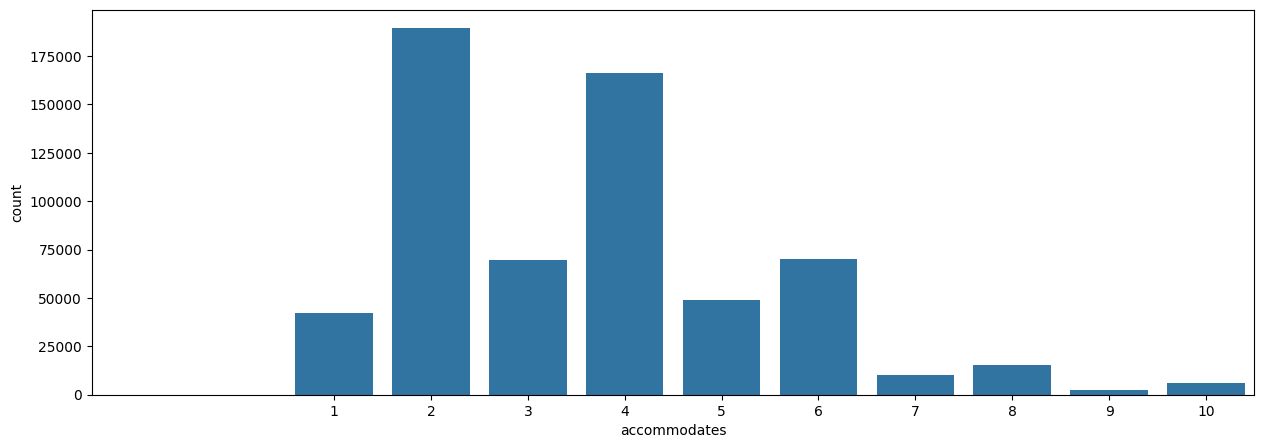

In [18]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [19]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print(f'{linhas_removidas} linhas removidas')

11569 linhas removidas


### bathrooms

<Axes: xlabel='bathrooms', ylabel='count'>

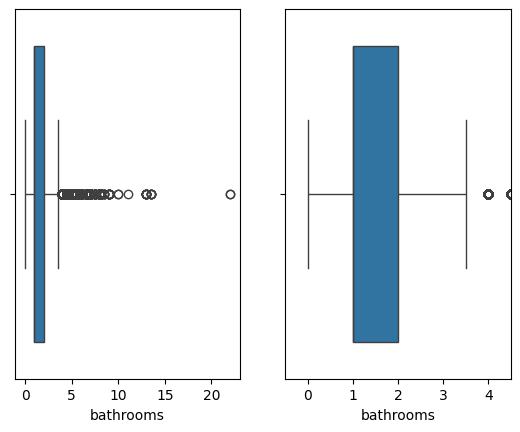

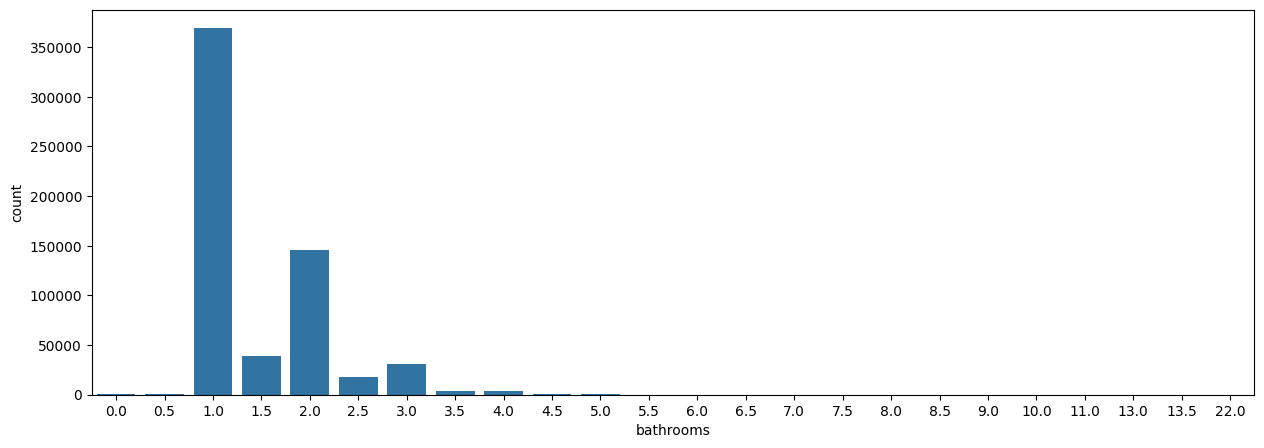

In [20]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index ,y=base_airbnb['bathrooms'].value_counts())

In [21]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print(f'{linhas_removidas} linhas removidas')

1588 linhas removidas


### bedrooms e beds

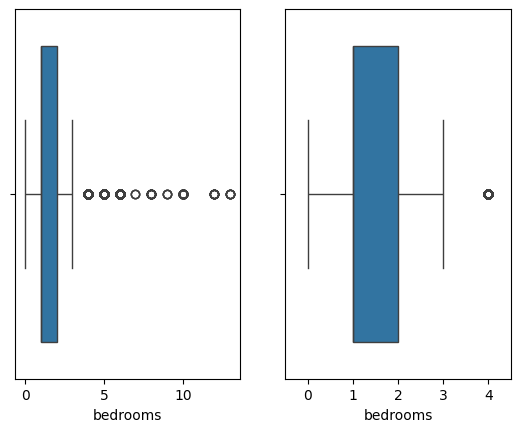

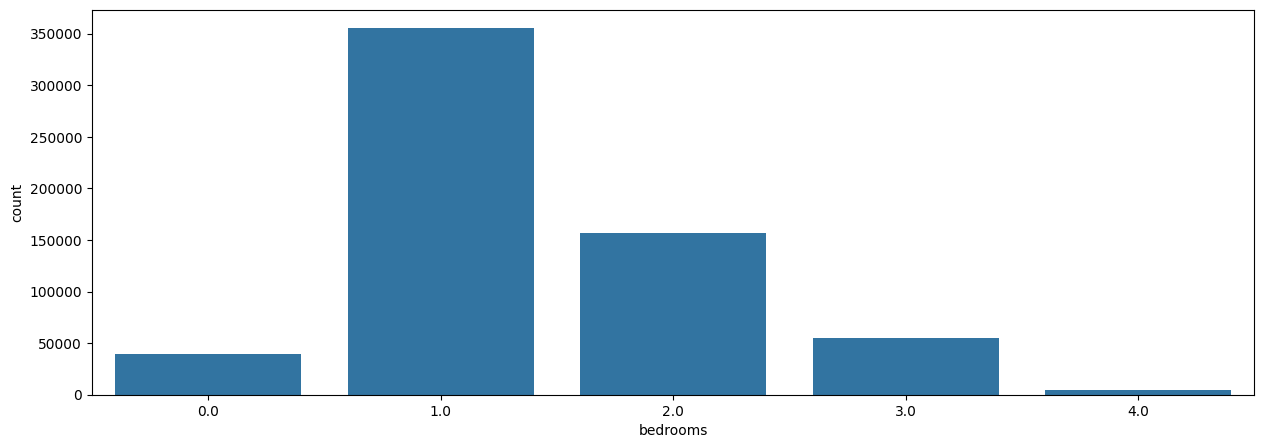

In [22]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [23]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print(f'{linhas_removidas} linhas removidas')

743 linhas removidas


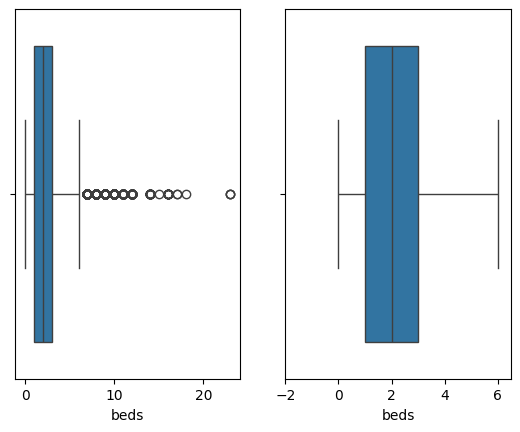

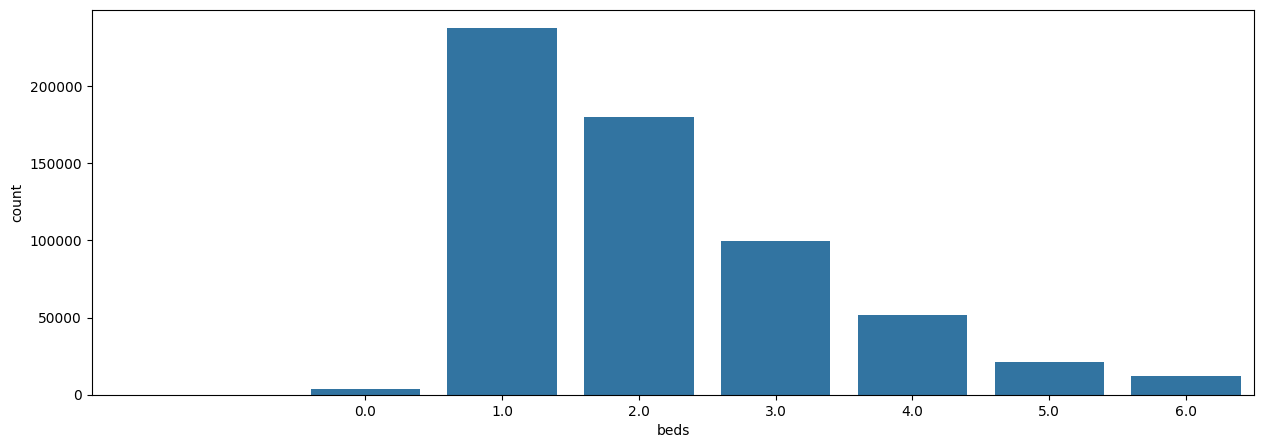

In [24]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [25]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print(f'{linhas_removidas} linhas removidas')

6380 linhas removidas


### guests_included

<Axes: xlabel='guests_included', ylabel='count'>

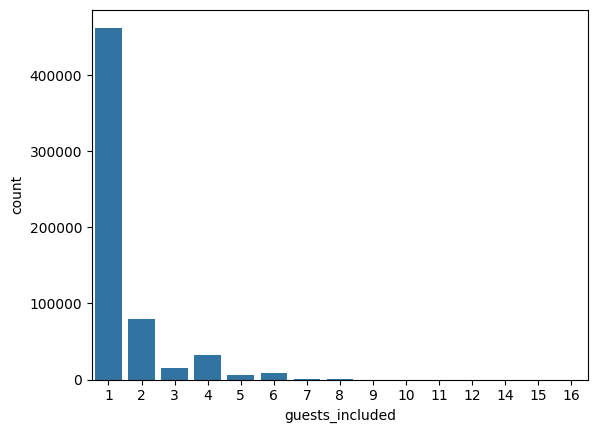

In [26]:
#diagrama_caixa(base_airbnb['guests_included'])
#grafico_barra(base_airbnb['guests_included'])

sns.barplot(x=base_airbnb['guests_included'].value_counts().index ,y=base_airbnb['guests_included'].value_counts())

Vamos remover essa feature da analise parece que os usuarios do airbnb usam o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para definição de preço, por isso, me parece melhor excluir a coluna da analise

In [27]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(605542, 22)

### minimum_nights  maximum_nights    

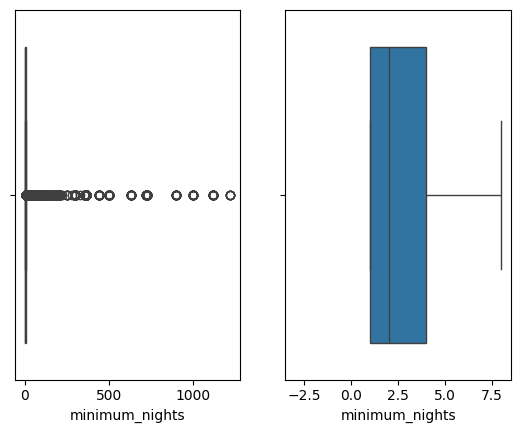

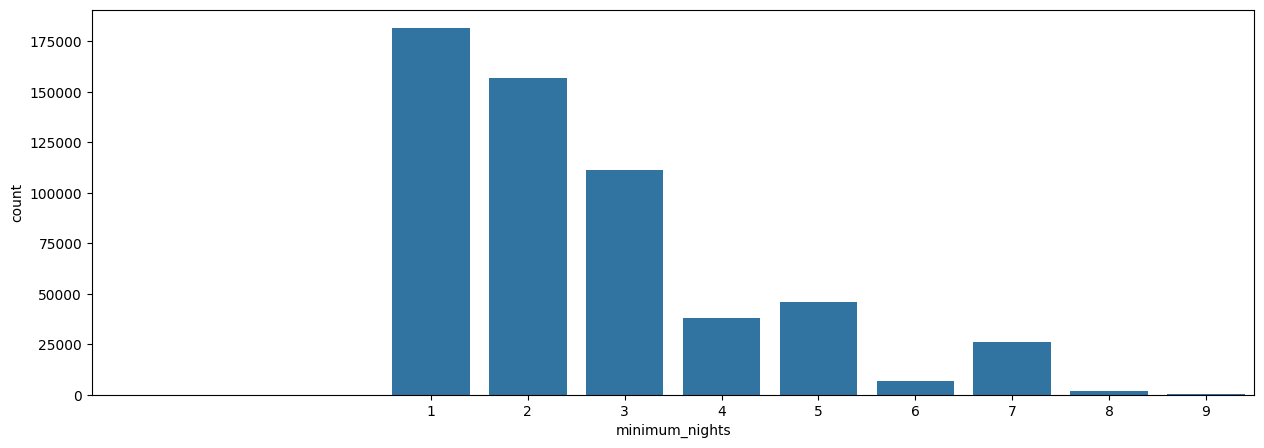

In [28]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [29]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print(f'{linhas_removidas} linhas removidas')

37892 linhas removidas


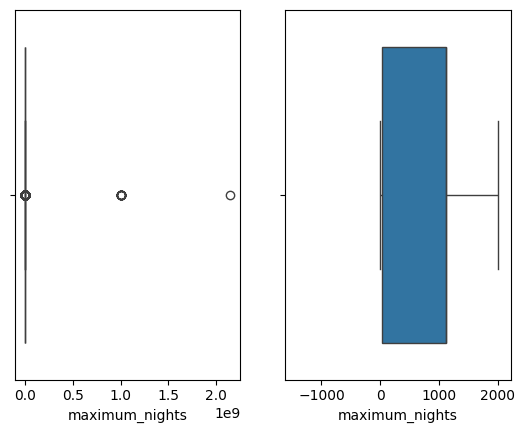

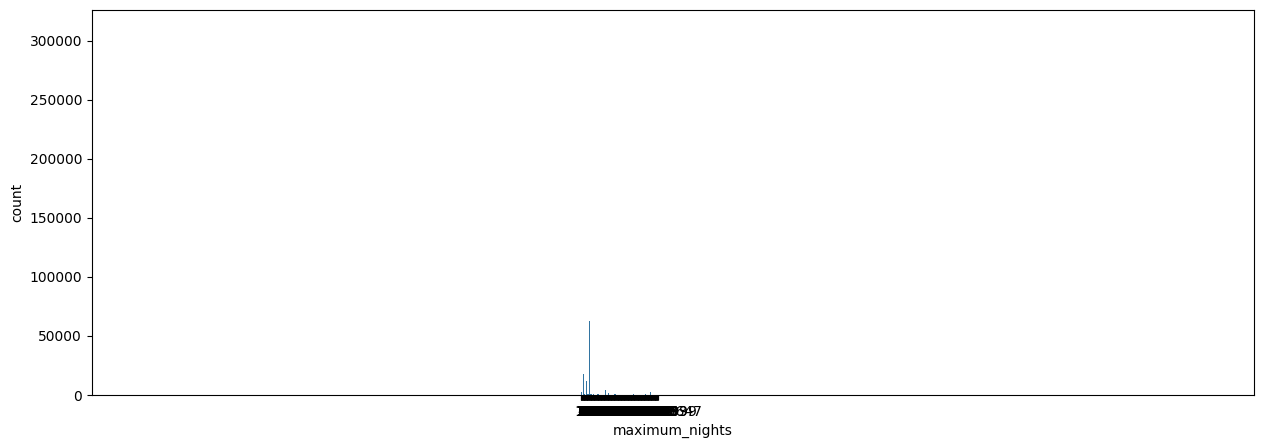

In [30]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [31]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(567650, 21)

### number_of_reviews             

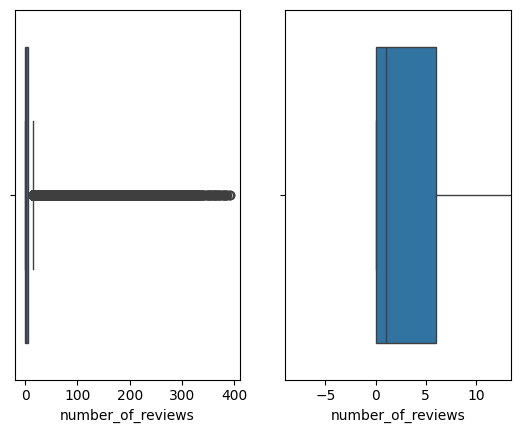

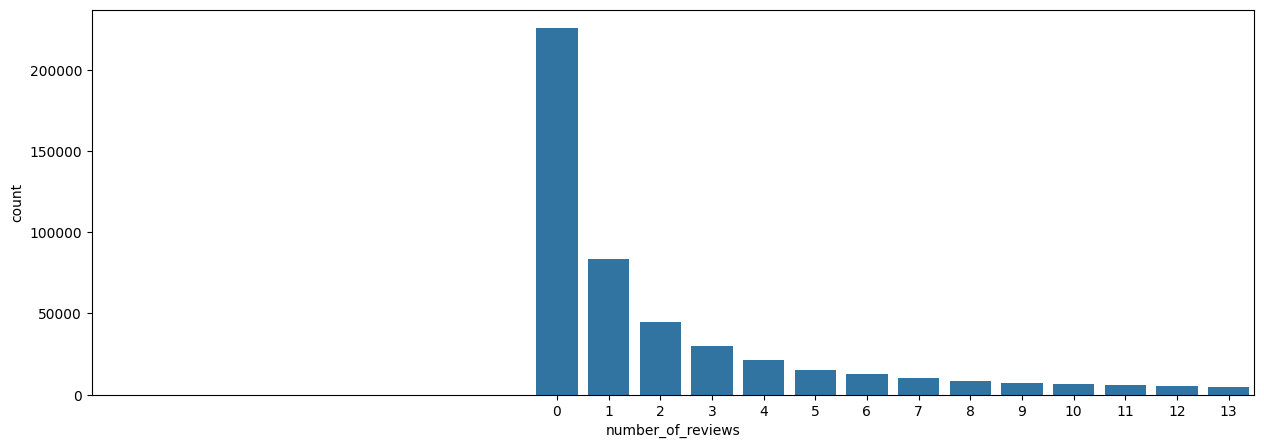

In [32]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [33]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(567650, 20)

### Tratamento de colunas de valores de texto


- property_type

property_type
Apartment                 445240
House                      51440
Condominium                26077
Serviced apartment         12373
Loft                       11962
Guest suite                 3627
Bed and breakfast           3462
Hostel                      2673
Guesthouse                  2063
Other                       1907
Villa                       1276
Townhouse                    959
Aparthotel                   670
Earth house                  488
Chalet                       473
Tiny house                   456
Boutique hotel               447
Hotel                        372
Casa particular (Cuba)       307
Cottage                      254
Bungalow                     200
Dorm                         184
Cabin                        142
Nature lodge                 124
Treehouse                     76
Castle                        57
Island                        54
Hut                           40
Boat                          35
Resort                       

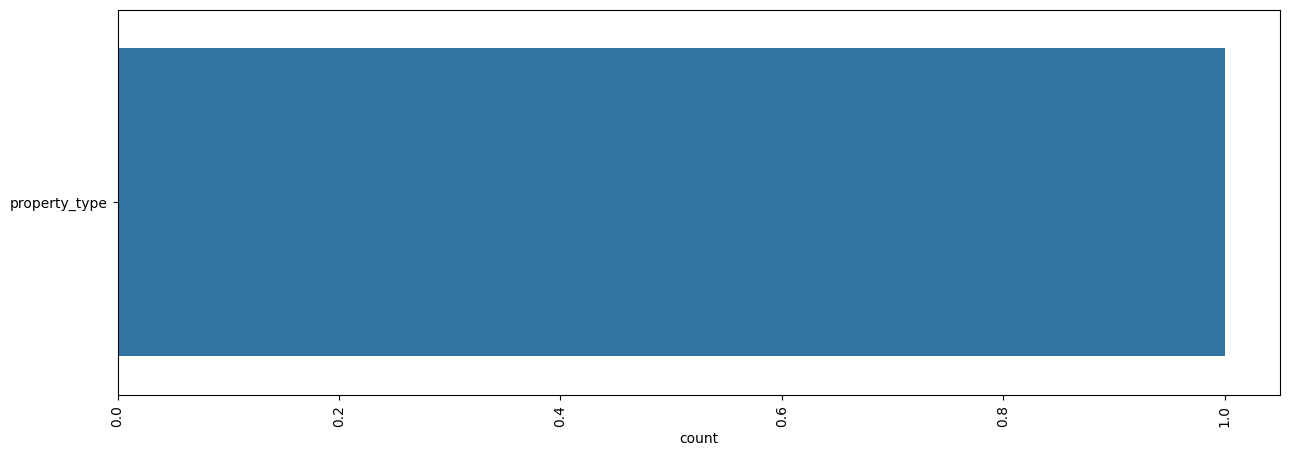

In [34]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type')
grafico.tick_params(axis='x', rotation=90)

In [35]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []
for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())


['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Earth house', 'Chalet', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Treehouse', 'Castle', 'Island', 'Hut', 'Boat', 'Resort', 'Campsite', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'In-law', 'Igloo', 'Vacation home', 'Timeshare', 'Pousada', 'Casa particular', 'Plane']
property_type
Apartment             445240
House                  51440
Condominium            26077
Serviced apartment     12373
Loft                   11962
Outros                  8733
Guest suite             3627
Bed and breakfast       3462
Hostel                  2673
Guesthouse              2063
Name: count, dtype: int64


### room_type

room_type
Entire home/apt    361118
Private room       194014
Shared room         11566
Hotel room            952
Name: count, dtype: int64


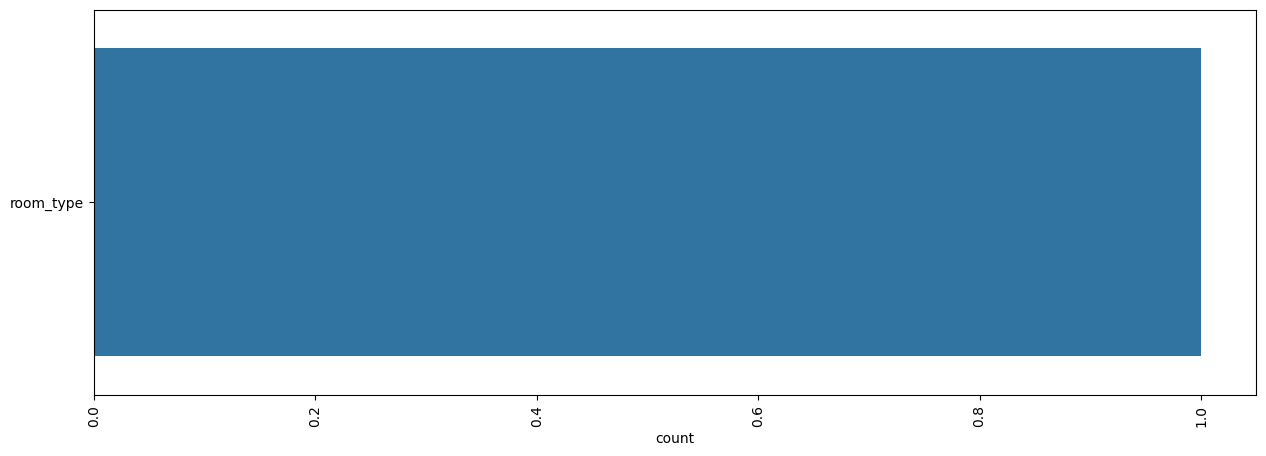

In [36]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('room_type')
grafico.tick_params(axis='x', rotation=90)

### bed_type

bed_type
Real Bed         556538
Pull-out Sofa      7884
Futon              1595
Airbed             1155
Couch               478
Name: count, dtype: int64


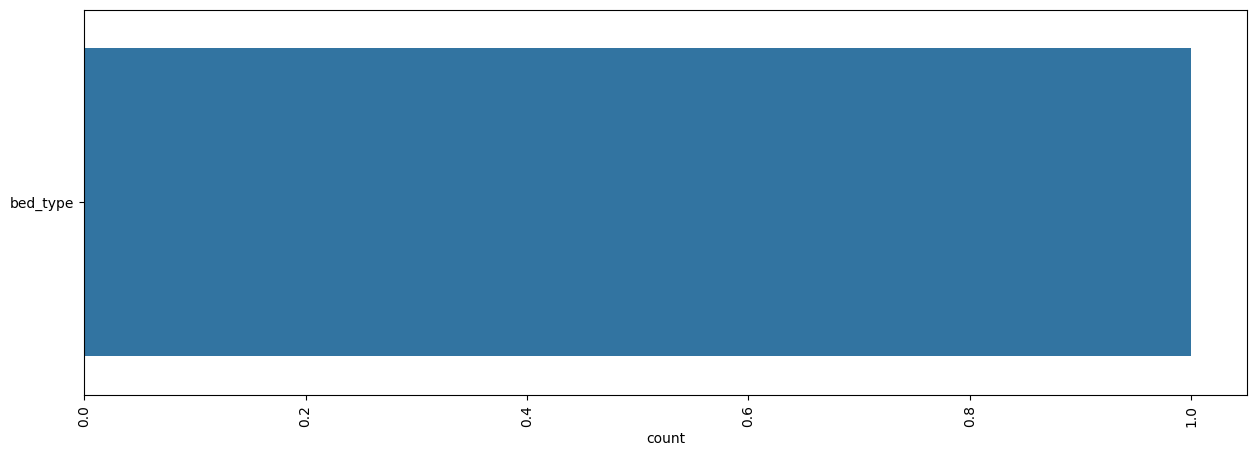

In [37]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type')
grafico.tick_params(axis='x', rotation=90)

In [38]:
tabela_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Outros'

print(base_airbnb['bed_type'].value_counts())


['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
bed_type
Real Bed    556538
Outros       11112
Name: count, dtype: int64


### cancellation_policy

cancellation_policy
flexible                       250743
strict_14_with_grace_period    195991
moderate                       111259
strict                           9506
super_strict_60                   120
super_strict_30                    31
Name: count, dtype: int64


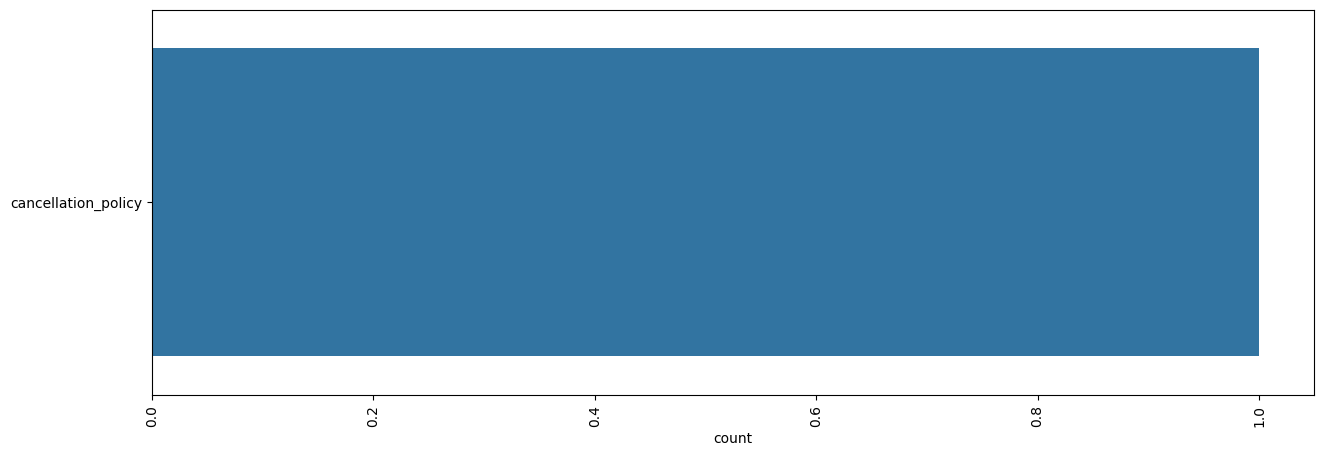

In [39]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy')
grafico.tick_params(axis='x', rotation=90)

In [40]:
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())


['strict', 'super_strict_60', 'super_strict_30']
cancellation_policy
flexible                       250743
strict_14_with_grace_period    195991
moderate                       111259
strict                           9657
Name: count, dtype: int64


### amenities

- Como temos uma diversidade muito grande de amenities e, as vezes as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para nosso modelo.

In [41]:
print(base_airbnb['amenities'].iloc[0].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)


['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Front desk/doorperson"', '"Private entrance"', '"Hot water"', '"Bed linens"', '"Luggage dropoff allowed"}']
14


In [42]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape


(567650, 20)

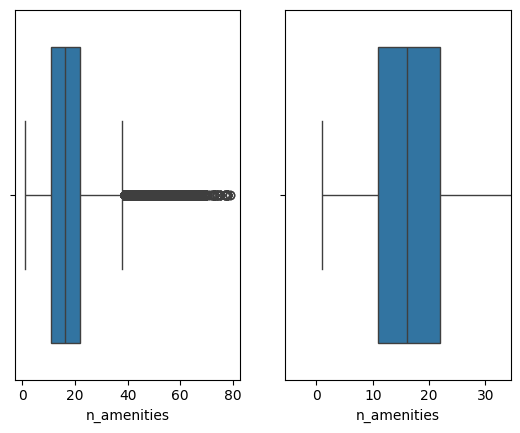

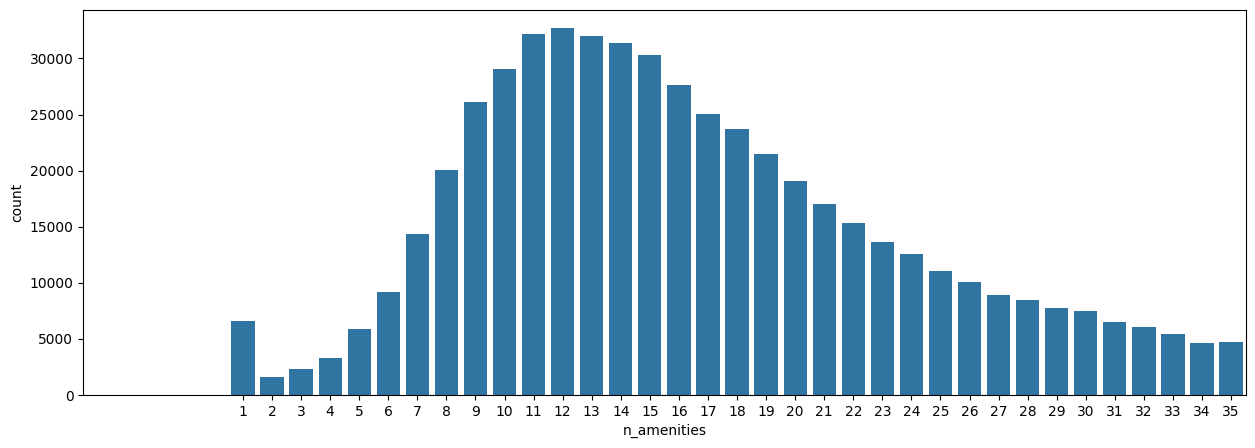

In [43]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [44]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

39058 linhas removidas


### VISUALIZAÇÃO DE MAPA DAS PROPRIEDADES

In [45]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5,
                        center = centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')
mapa.show()

### Encoding

Precisamos ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)
 - Features de valores True ou False, vamos substituir True por 1 e False por 0.
 - Features de Categorias (features em que os valores da coluna são textos) vamos utilizar o metodo de encoding de variaveis dummies

In [46]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
     base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t' ,coluna] = 1
     base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f' ,coluna] = 0

In [47]:
colunas_categorias = ['property_type','room_type','bed_type','cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias, dtype=int)
display(base_airbnb_cod.head())

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Outros,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
1,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,1,0,0,0,0,1,0,0,1,0
3,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,1,0,0,0,0,1,0,0,1,0
4,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,1,0,0,0,0,1,0,0,1,0
5,1,1.0,-22.988165,-43.193588,3,1.5,1.0,2.0,308.0,86.0,...,1,0,0,0,0,1,0,0,1,0
6,1,1.0,-22.981269,-43.190457,2,1.0,1.0,2.0,219.0,80.0,...,1,0,0,0,0,1,0,0,1,0


### Modelo de Previsão

In [48]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR2:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos modelos a serem testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree


In [49]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression ()
modelo_et = ExtraTreesRegressor()
modelos = {'RandomForest': modelo_rf,
           'LinearRegression': modelo_lr,
           'ExtraTrees': modelo_et
           }
y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

- Separação os dados de treino e teste + treino do modelo

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    # treinar
    modelo.fit(x_train, y_train)
    # testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R2:96.99%
RSME:40.99
Modelo LinearRegression:
R2:33.30%
RSME:192.85
Modelo ExtraTrees:
R2:97.35%
RSME:38.46


### Análise do Melhor Modelo

In [51]:
for nome_modelo, modelo in modelos.items():
     # testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R2:96.99%
RSME:40.99
Modelo LinearRegression:
R2:33.30%
RSME:192.85
Modelo ExtraTrees:
R2:97.35%
RSME:38.46


- Modelo escolhido como Melhor Modelo: ExtraTressRegressor

    Modelo de maior R2 e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados proximos) vamos escolher o modelo ExtraTress

### Ajustes e Melhorias no Melhor Modelo

[0.01199837 0.0404051  0.10294241 0.09950897 0.08330754 0.06225703
 0.11090953 0.0503688  0.09010644 0.06223998 0.02054588 0.
 0.01144785 0.00484374 0.08685494 0.01297505 0.00141313 0.00519227
 0.00069134 0.00062071 0.00081913 0.00774227 0.00203528 0.00277915
 0.00233708 0.07183639 0.00028704 0.00451409 0.00191815 0.00293849
 0.00307549 0.01826729 0.01320007 0.00101505 0.00860597]


,0
bedrooms,0.110910
latitude,0.102942
longitude,0.099509
extra_people,0.090106
n_amenities,0.086855
accommodates,0.083308
room_type_Entire home/apt,0.071836
bathrooms,0.062257
minimum_nights,0.062240
beds,0.050369


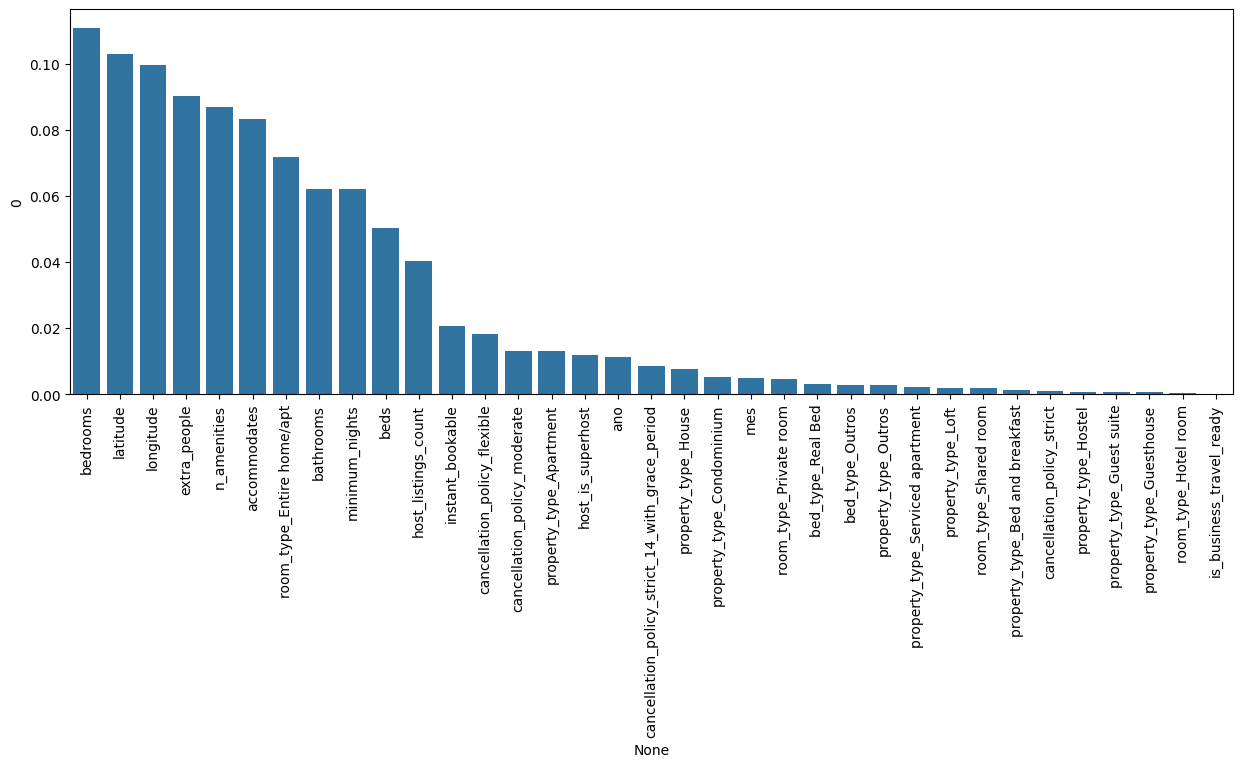

In [52]:
print(modelo_et.feature_importances_)
importancia_features = pd.DataFrame(modelo_et.feature_importances_, x_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### AJUSTES FINAIS NO MODELO

- is_business_travel ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir está feature e testar o modelo sem ela.

In [53]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

modelo_et.fit(x_train, y_train)
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTress', y_test, previsao))

Modelo ExtraTress:
R2:97.35%
RSME:38.46


In [54]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop(coluna, axis=1)
y = base_teste['price']
x = base_teste.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

modelo_et.fit(x_train, y_train)
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTress', y_test, previsao))

Modelo ExtraTress:
R2:97.33%
RSME:38.58


In [55]:
x['price'] = y
x.to_csv('dados.csv')

In [56]:
import joblib

joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']